In [67]:
import torch
import matplotlib.pyplot as plt
from gatys import  image_loader, imshow, run_style_transfer
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from style_transfer_net import StyleTransferNet, adain, Decoder_1B, calc_mean_std
from test import load_one_img
from dataloader import create_dataloader
import numpy as np
import cv2
from tqdm import tqdm

## Dataset analysis

In [68]:
content_trainloader, style_trainloader = create_dataloader('data/40Ktrain', 'data/20Kwikiart', trainset=True, batch_size=8, shuffle=True)

In [69]:
print('Size content trainloader:', len(content_trainloader)*8)
print('Size style trainloader:', len(style_trainloader)*8)

Size content trainloader: 40000
Size style trainloader: 20000


In [70]:
content_testloader, style_testloader = create_dataloader('data/val2017', 'data/wikiart_small', trainset=False, batch_size=1, shuffle=True)

In [71]:
print('Size content testloader:', len(content_testloader)*1)
print('Size style testloader:', len(style_testloader)*1)

Size content testloader: 5002
Size style testloader: 2003


## Load images

In [72]:
def center_crop(image, width=512, height=512):
    assert width or height, 'At least one of width or height must be specified!'
    # use specified value, or fall back to the other one
    width = width or height
    height = height or width
    # determine/calculate relevant values
    old_height, old_width = image.shape[:2]
    c_x, c_y = old_width // 2, old_height // 2
    dx, dy = width // 2, height // 2
    # perform the crop
    return image[c_y-dy:c_y+dy, c_x-dx:c_x+dx]

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [74]:
# test_style_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/nicholas-roerich_tibet-1933-1.jpg" #work bad
# test_style_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/miriam-schapiro_fanfare-1968.jpg" #work good
# test_content_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/000000581357.jpg" # Skateboarder
# test_content_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/brad_pitt.jpg" # Brad Pitt
# test_style_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/picasso_self_portrait.jpg" #work good
# test_content_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/lenna.jpg"  # Lenna
# test_style_img = "/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/picasso_seated_nude_hr.jpg" #work good
# mikhail-vrubel_thirty-three-knights-1901
test_style_img = '/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/wikiart_small/ernst-ludwig-kirchner_two-women-at-the-street.jpg' 
test_content_img = '/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/data/val2017/000000076417.jpg'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


content_img = image_loader(loader,test_content_img,device)
style_img = image_loader(loader,test_style_img,device)

print(content_img.size(),style_img.size())

if content_img.size()[2]*content_img.size()[3] > style_img.size()[2]*style_img.size()[3]:
    print("resizing")
    resized_content_img = transforms.functional.crop(content_img,0,0,style_img.size()[2],style_img.size()[3])
    resized_style_img = style_img
    print(resized_content_img.size(),style_img.size())
elif content_img.size()[2]*content_img.size()[3] < style_img.size()[2]*style_img.size()[3]:
    print("resizing")
    resized_style_img = transforms.functional.crop(style_img,0,0,content_img.size()[2],content_img.size()[3])
    resized_content_img = content_img
    print(content_img.size(),style_img.size())

assert resized_style_img.size() == resized_content_img.size(), \
    "For Gatys, we need to import style and content images of the same size"

torch.Size([1, 3, 128, 171]) torch.Size([1, 3, 173, 128])
resizing
torch.Size([1, 3, 128, 171]) torch.Size([1, 3, 173, 128])


## Tests on Gatys et al Neural-Style algorithm

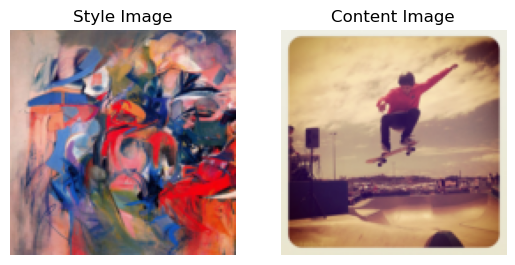

In [61]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

fig, ax = plt.subplots(1,2)
imshow(ax[0],resized_style_img,unloader, title='Style Image')
imshow(ax[1], resized_content_img,unloader, title='Content Image')

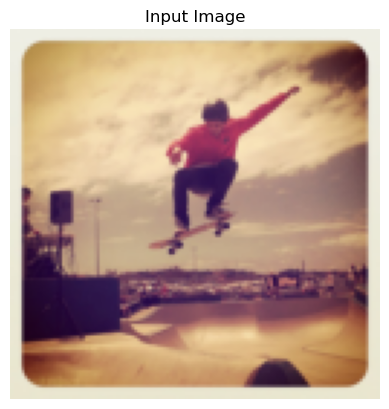

In [62]:
input_img = resized_content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
fig, ax = plt.subplots(1,1)
imshow(ax, input_img, unloader, title='Input Image')

In [63]:
original_model = vgg19(weights=VGG19_Weights.DEFAULT)
# original_model.named_parameters

In [65]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            resized_content_img, resized_style_img, input_img, num_steps=1000)


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 122.091209 Content Loss: 34.700359

run [100]:
Style Loss : 62.773346 Content Loss: 36.405334

run [150]:
Style Loss : 36.458988 Content Loss: 37.010651

run [200]:
Style Loss : 22.882576 Content Loss: 36.821869

run [250]:
Style Loss : 16.355387 Content Loss: 36.122379

run [300]:
Style Loss : 13.285296 Content Loss: 35.287704

run [350]:
Style Loss : 11.349135 Content Loss: 34.558949

run [400]:
Style Loss : 10.103064 Content Loss: 34.043400

run [450]:
Style Loss : 9.314989 Content Loss: 33.589020

run [500]:
Style Loss : 8.745955 Content Loss: 33.212292

run [550]:
Style Loss : 8.370065 Content Loss: 32.892277

run [600]:
Style Loss : 8.011120 Content Loss: 32.629814

run [650]:
Style Loss : 7.759058 Content Loss: 32.377472

run [700]:
Style Loss : 7.524924 Content Loss: 32.189438

run [750]:
Style Loss : 7.363492 Content Loss: 31.996855

run [800]:
Style Loss : 7.227283 Content Loss: 31.842365

run [850]:
Styl

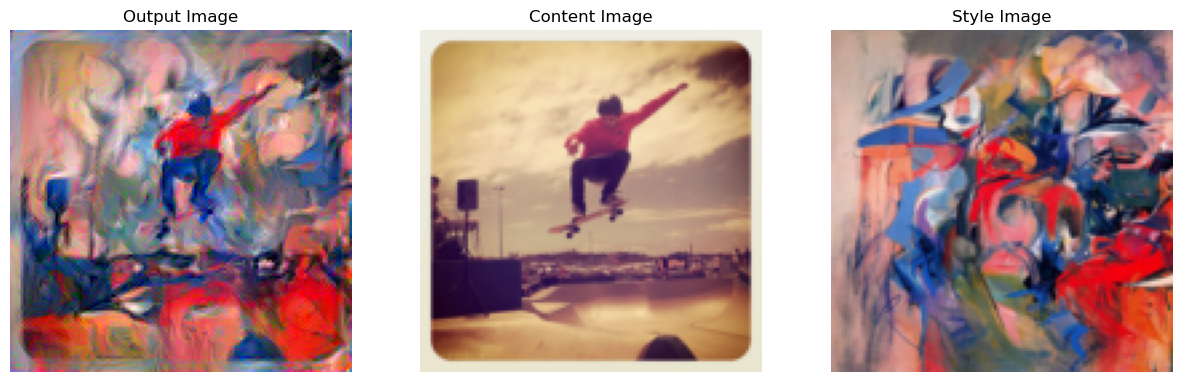

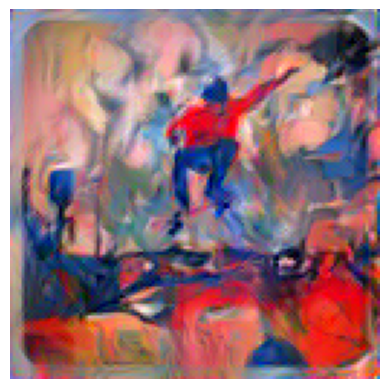

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
imshow(ax[0], output, unloader, title='Output Image')
imshow(ax[1], resized_content_img,unloader, title='Content Image')
imshow(ax[2], resized_style_img,unloader, title='Style Image')
plt.show()

plt.figure()
plt.imshow(center_crop(output.detach().cpu().numpy().squeeze(0).transpose(1,2,0)))
plt.axis('off')
plt.show()

## AdaIN style transfer

In [77]:
model = StyleTransferNet(alpha = 1.0,skip_connections=False,normed_vgg=True).to(device)
    
model_path = '/Users/Hippolyte/Desktop/MVA/Image generation/AdaIN-Project/models/3decoder_epoch_30.pth.tar' 
state_dict = torch.load(model_path, map_location=device)
# print(state_dict.keys())
# print('Decoder state dict keys:', model.decoder.state_dict().keys())
# for _ in range(len(state_dict)):
#     k, v = state_dict.popitem(False)
#     if int(str(k)[8]) == 4:
#         state_dict[str(k)] = v
#     else:
#         if float(str(k)[10:12]) < 10:
#             state_dict[str(k)[:10]+str(int(str(k)[10])-1)+str(k)[11:]] = v
#         else:
#             state_dict[str(k)[:10]+str(int(str(k)[10:12])-1)+str(k)[12:]] = v
model.decoder.load_state_dict(state_dict=state_dict)
style_weight = 10

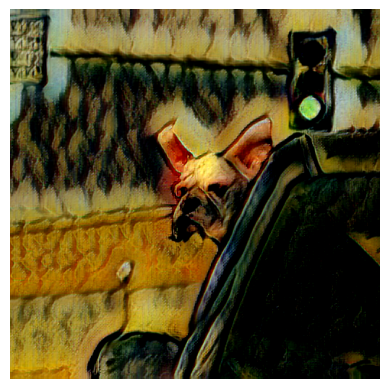

In [80]:
with torch.no_grad():
    content_img = load_one_img(test_content_img).to(device)
    style_img = load_one_img(test_style_img).to(device)


    output, t = model.forward(content_img.unsqueeze(0), style_img.unsqueeze(0))
    styled_img = output.squeeze(0)


    content_img = content_img.detach(
    ).cpu().numpy().transpose(1, 2, 0)
    # Ensure the image is in the 0-1 range
    content_img = np.clip(content_img, 0, 1)

    style_img = style_img.detach(
    ).cpu().numpy().transpose(1, 2, 0)
    # Ensure the image is in the 0-1 range
    style_img = np.clip(style_img, 0, 1)
    
    # Display the styled images
    styled_img = styled_img.detach(
    ).cpu().numpy().transpose(1, 2, 0)
    # Ensure the image is in the 0-1 range
    styled_img = np.clip(styled_img, 0, 1)

    
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # ax[0].imshow(center_crop(content_img))
    # ax[0].set_title('Content Image')
    # ax[0].axis('off')
    # ax[1].imshow(center_crop(style_img))
    # ax[1].set_title('Style Image')
    # ax[1].axis('off')
    # ax[2].imshow(center_crop(styled_img))
    # ax[2].set_title('Model output')
    # ax[2].axis('off')
    # fig.savefig('results/Images_test_'+'model_name'+'.png')
    plt.figure()
    plt.imshow(center_crop(styled_img))
    plt.axis('off')
    plt.show()

In [17]:
model.eval()
mse_loss = torch.nn.MSELoss()
eval_decoder_loss = []
eval_content_loss = []
eval_style_loss = []
content_loss = 0
style_loss = 0
with torch.no_grad():
    for i, (content_imgs, style_imgs) in tqdm(enumerate(zip(content_testloader, style_testloader))):
        if i%8 == 0 and i != 0:
            decoder_loss = content_loss + style_weight * style_loss
            eval_decoder_loss.append(decoder_loss.item())
            eval_content_loss.append(content_loss.item())
            eval_style_loss.append(style_loss.item())
            content_loss = 0
            style_loss = 0
            
        content_batch = content_imgs.to(device)
        style_batch = style_imgs.to(device)

        output, t = model.forward(content_batch, style_batch)
        invert_output = model.encoder(output)
        styled_images = output
        # compute the content loss
        assert (t.requires_grad is False)
        content_loss += mse_loss(invert_output, t)

        # compute the style loss
        for j in range(4):
            # Take the accurate layer from the encoder
            layer = getattr(model.encoder, 'encoder_{:d}'.format(j + 1))
            style_batch = layer(style_batch)
            output = layer(output)
            assert (style_batch.requires_grad is False)
            meanS, stdS = calc_mean_std(style_batch)
            meanG, stdG = calc_mean_std(output)
            style_loss += mse_loss(meanS, meanG) + mse_loss(stdS, stdG)
        if i == 50:
            break



50it [06:18,  7.56s/it]


In [20]:
print('Valid Content loss: ', np.mean(np.array(eval_content_loss)), 'Valid Style loss: ', np.mean(np.array(eval_style_loss)),
    'Valid Total loss: ', np.mean(np.array(eval_decoder_loss)))

Valid Content loss:  206.91912587483725 Valid Style loss:  163.85438283284506 Valid Total loss:  1845.462910970052
